2025-06-10 13:02:55,166 | INFO    | ==========  STAGE 05A: BEST-RATIO + QUINTILES ==========
2025-06-10 13:02:55,168 | INFO    | SWAN_YEAR=2008  RUN_DATE=20250609  RUN_DIR=C:\Users\Jason Pohl\OneDrive - Bond University\PhD\rff\outputs_rff\event=2008\20250609
2025-06-10 13:02:55,171 | INFO    | Bucket map loaded: 231 ratios → 16 buckets
2025-06-10 13:02:55,175 | INFO    | Stage-4 ranking loaded: 1270 rows × 6 cols
2025-06-10 13:02:55,238 | WARNING | No surviving ratios for bucket(s): Cog-Prepare
2025-06-10 13:02:55,241 | INFO    | ✓  Best-per-bucket CSV → C:\Users\Jason Pohl\OneDrive - Bond University\PhD\rff\outputs_rff\event=2008\20250609\stage05a\Stage5A_BestRatioPerBucket.csv

✅  BEST RATIO PER BUCKET (full table)  ✅
      Bucket                           Ratio  AvgRho  Coverage%
  Cog-Absorb           GrossProfit_to_Equity  0.1209       96.6
   Cog-Adapt              Market_Share_Ratio  0.2653      100.0
 Cog-Recover                       NOPAT_Alt  0.3412       58.1
 Info-Absorb  

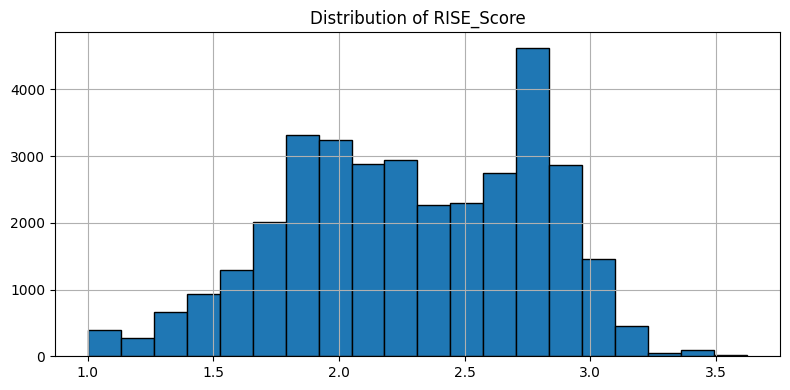

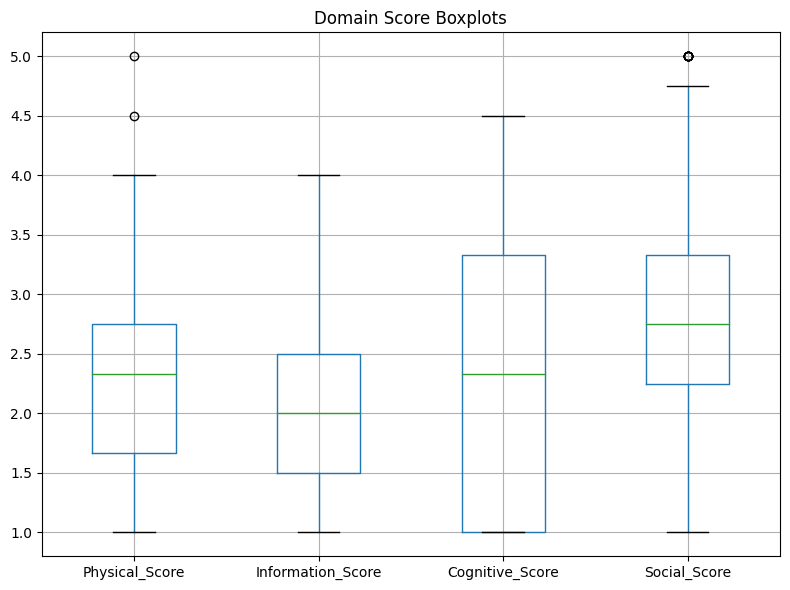

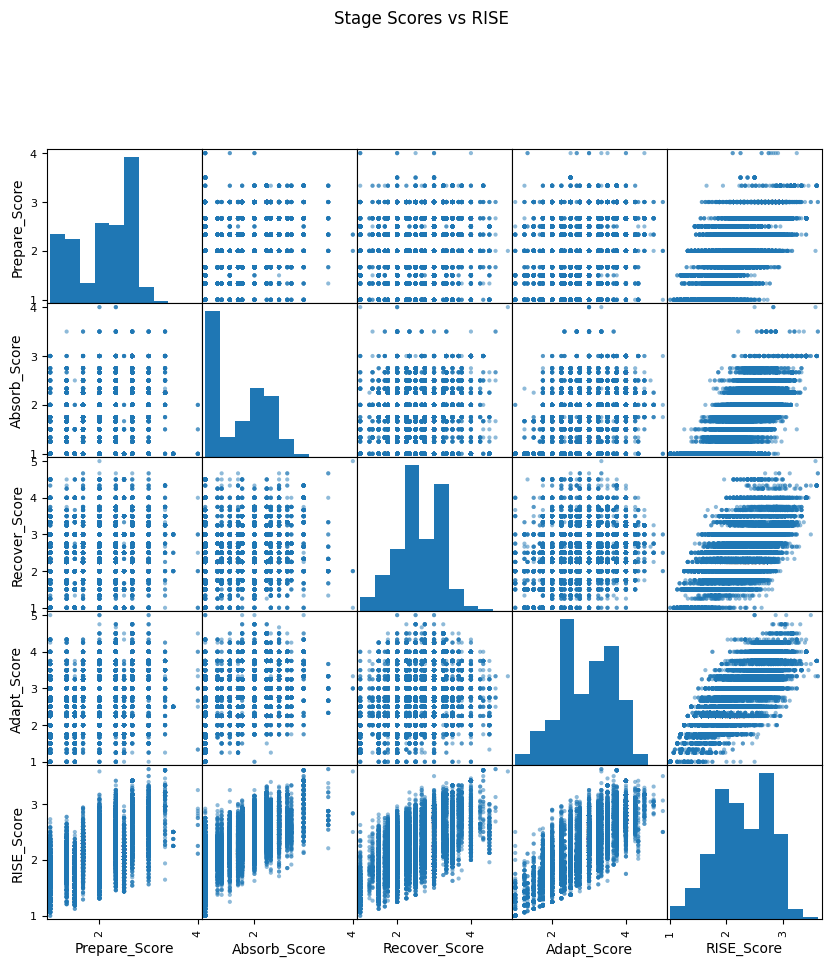

2025-06-10 13:03:22,494 | INFO    | ✅  STAGE 05A complete – artefacts in C:\Users\Jason Pohl\OneDrive - Bond University\PhD\rff\outputs_rff\event=2008\20250609\stage05a


In [3]:
#!/usr/bin/env python
"""
Stage 05A · Best-Per-Bucket  +  Quintiles & Scores
==================================================

Merged successor of the legacy “Stage 5A” and “Stage 5B”.

Key improvements
----------------
1. 100 % dynamic run-folder discovery — no numeric folder assumption.
2. `RUN_DIR` / `RUN_DATE` / `SWAN_YEAR` / `PIPELINE_CFG` env overrides.
3. Re-uses in-memory DataFrames when Stage 03/04 executed earlier
   in the same session.
4. Outputs written to  <RUN_DIR>/stage05a/   (folder auto-created).

Artefacts
---------
stage05a/
    ├─ Stage5A_BestRatioPerBucket.csv
    ├─ Stage5A_QuintilesAndScores.csv
    └─ stage05a.log
"""

from __future__ import annotations

# ── imports ──────────────────────────────────────────────────────────
from pathlib import Path
import os, sys, logging, yaml, warnings
from typing import Dict, List, Set

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# ╔══════════════════════════════════════════════════════════════════╗
# 0 · PIPELINE CONFIG & LOGGER                                       #
# ╚══════════════════════════════════════════════════════════════════╝
CFG_FILE = Path(os.getenv("PIPELINE_CFG", "pipeline_config.yaml")).expanduser()
if not CFG_FILE.is_file():
    raise FileNotFoundError(f"pipeline_config.yaml not found at {CFG_FILE}")

with CFG_FILE.open(encoding="utf-8") as fh:
    CFG: Dict = yaml.safe_load(fh) or {}

DEFAULTS   = CFG.get("defaults", {})
EVENTS     = {str(k): v for k, v in CFG.get("events", {}).items()}
ST5_OVR    = CFG.get("stage5", {})

SWAN_YEAR  = int(os.getenv("SWAN_YEAR", next(iter(EVENTS))))
if str(SWAN_YEAR) not in EVENTS:
    raise KeyError(f"SWAN_YEAR={SWAN_YEAR} missing in pipeline_config events:")

DATE_COL   = ST5_OVR.get("date_col", "ReportDate")
ID_COL     = ST5_OVR.get("id_col",   "Symbol")

# ╔══════════════════════════════════════════════════════════════════╗
# 1 · PATH RESOLUTION                                                #
# ╚══════════════════════════════════════════════════════════════════╝
OUTPUT_ROOT = Path(DEFAULTS["OUTPUT_ROOT"]).expanduser()
EVENT_DIR   = OUTPUT_ROOT / f"event={SWAN_YEAR}"

# explicit override
RUN_DIR: Path | None = None
if os.getenv("RUN_DIR"):
    RUN_DIR = Path(os.getenv("RUN_DIR")).expanduser()
elif os.getenv("RUN_DATE"):
    RUN_DIR = EVENT_DIR / os.getenv("RUN_DATE")

# auto-discover latest Stage-04 file if RUN_DIR still None
if RUN_DIR is None:
    if not EVENT_DIR.is_dir():
        raise FileNotFoundError(f"No outputs for event={SWAN_YEAR} in {EVENT_DIR}")
    candidates = list(EVENT_DIR.glob("*/stage04/Stage4_winsor_RatioRanking.csv"))
    if not candidates:
        raise FileNotFoundError(
            f"No Stage4_winsor_RatioRanking.csv found under {EVENT_DIR}. Run Stage 04."
        )
    RANK_FILE = max(candidates, key=lambda p: p.stat().st_mtime)
    RUN_DIR   = RANK_FILE.parents[1]
else:
    RANK_FILE = RUN_DIR / "stage04" / "Stage4_winsor_RatioRanking.csv"
    if not RANK_FILE.is_file():
        raise FileNotFoundError(f"{RANK_FILE} not found – run Stage 04 first")

RUN_DATE   = RUN_DIR.name
STAGE3_DIR = RUN_DIR / "stage03"
STAGE4_DIR = RUN_DIR / "stage04"

STAGE5A_DIR = RUN_DIR / "stage05a"
STAGE5A_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR = STAGE5A_DIR

# ── logger ──────────────────────────────────────────────────────────
logging.basicConfig(
    level   = logging.INFO,
    format  = "%(asctime)s | %(levelname)-7s | %(message)s",
    handlers=[
        logging.FileHandler(OUT_DIR / "stage05a.log", mode="w", encoding="utf-8"),
        logging.StreamHandler(sys.stdout),
    ],
)
logger = logging.getLogger(__name__)
logger.info("==========  STAGE 05A: BEST-RATIO + QUINTILES ==========")
logger.info("SWAN_YEAR=%s  RUN_DATE=%s  RUN_DIR=%s", SWAN_YEAR, RUN_DATE, RUN_DIR)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# ╔══════════════════════════════════════════════════════════════════╗
# 2 · RATIO → BUCKET MAP                                             #
# ╚══════════════════════════════════════════════════════════════════╝
if "ratio_domain_stage_map" in globals() and globals()["ratio_domain_stage_map"]:
    ratio_to_buckets: Dict[str, List[str]] = {
        r: (bs if isinstance(bs, (list, tuple)) else [bs])
        for r, bs in globals()["ratio_domain_stage_map"].items()
    }
else:  # fallback YAML
    map_file = Path("ratio_domain_stage_map.yaml")
    if not map_file.is_file():
        raise RuntimeError("ratio_domain_stage_map missing – run Stage 03 first "
                           "or provide ratio_domain_stage_map.yaml")
    ratio_to_buckets = {
        r: (bs if isinstance(bs, (list, tuple)) else [bs])
        for r, bs in yaml.safe_load(map_file.read_text()).items()
    }
all_buckets: Set[str] = {b for v in ratio_to_buckets.values()
                         for b in (v if isinstance(v, (list, tuple)) else [v])}
logger.info("Bucket map loaded: %d ratios → %d buckets",
            len(ratio_to_buckets), len(all_buckets))

# ╔══════════════════════════════════════════════════════════════════╗
# 3 · LOAD STAGE-4 RANKING                                           #
# ╚══════════════════════════════════════════════════════════════════╝
rank_df = pd.read_csv(RANK_FILE)
logger.info("Stage-4 ranking loaded: %d rows × %d cols", *rank_df.shape)

# ╔══════════════════════════════════════════════════════════════════╗
# 4 · PICK BEST RATIO PER BUCKET                                     #
# ╚══════════════════════════════════════════════════════════════════╝
records: List[Dict] = []
for ratio, buckets in ratio_to_buckets.items():
    sub = rank_df[rank_df["Ratio"] == ratio]
    if sub.empty:
        continue
    avg_rho = sub["|rho|"].mean()
    max_cov = sub["Coverage%"].max()
    for bucket in buckets:
        records.append({"Bucket": bucket, "Ratio": ratio,
                        "AvgRho": round(avg_rho, 4),
                        "Coverage%": round(max_cov, 1)})

best_df = (pd.DataFrame(records)
           .sort_values(["Bucket", "AvgRho"], ascending=[True, False])
           .groupby("Bucket", as_index=False).first())

missing = all_buckets - set(best_df["Bucket"])
if missing:
    logger.warning("No surviving ratios for bucket(s): %s",
                   ", ".join(sorted(missing)))

best_csv = OUT_DIR / "Stage5A_BestRatioPerBucket.csv"
best_df.to_csv(best_csv, index=False)
logger.info("✓  Best-per-bucket CSV → %s", best_csv)

# ---- Notebook-friendly previews ------------------------------------
print("\n✅  BEST RATIO PER BUCKET (full table)  ✅")
print(best_df.to_string(index=False))

print("\n🏅  TOP-5 BUCKET WINNERS (highest AvgRho) 🏅")
print(best_df.sort_values("AvgRho", ascending=False)
              .head(5)
              .to_string(index=False))

print("\n🔻  BOTTOM-5 BUCKET WINNERS (lowest AvgRho) 🔻")
print(best_df.sort_values("AvgRho", ascending=True)
              .head(5)
              .to_string(index=False))

# ╔══════════════════════════════════════════════════════════════════╗
# 5 · LOAD STAGE-3 DATAFRAME                                         #
# ╚══════════════════════════════════════════════════════════════════╝
if "data_stage_3" in globals():
    df = globals()["data_stage_3"].copy()
    logger.info("Stage-3 data re-used from memory: %d rows", len(df))
else:
    stage3_csv = STAGE3_DIR / "Stage3_Data_WithRatios.csv"
    if not stage3_csv.is_file():
        # tolerate non-canonical filename
        cand = list(STAGE3_DIR.glob("*WithRatios.csv"))
        if not cand:
            raise FileNotFoundError("Stage-3 CSV not found; run Stage 03 first.")
        stage3_csv = cand[0]
    df = pd.read_csv(stage3_csv, parse_dates=[DATE_COL], low_memory=False)
    logger.info("Stage-3 CSV loaded: %d rows", len(df))

df.sort_values([ID_COL, DATE_COL], inplace=True)
df["Year"] = df[DATE_COL].dt.year

# ╔══════════════════════════════════════════════════════════════════╗
# 6 · QUINTILE CALCULATION                                           #
# ╚══════════════════════════════════════════════════════════════════╝
qcols: List[str] = []
for _, row in best_df.iterrows():
    bucket, ratio = row["Bucket"], row["Ratio"]
    qcol = f"{bucket}_Q"
    qcols.append(qcol)
    if ratio not in df.columns or df[ratio].notna().sum() < 5:
        df[qcol] = np.nan
        continue
    try:
        _, bins = pd.qcut(df[ratio].dropna(), q=5, retbins=True, duplicates="drop")
        labels  = list(range(1, len(bins)))
        df[qcol] = pd.cut(df[ratio], bins=bins, labels=labels,
                          include_lowest=True).astype(float)
    except ValueError:
        df[qcol] = np.nan
logger.info("Quintile columns created: %d", len(qcols))

# ╔══════════════════════════════════════════════════════════════════╗
# 7 · DOMAIN / STAGE SCORES + RISE                                   #
# ╚══════════════════════════════════════════════════════════════════╝
domain_map = {"Phys": "Physical", "Info": "Information",
              "Cog":  "Cognitive", "Soc": "Social"}
stage_names = ["Prepare", "Absorb", "Recover", "Adapt"]

# domain scores
for pfx, full in domain_map.items():
    cols = [c for c in qcols if c.startswith(f"{pfx}-")]
    df[f"{full}_Score"] = df[cols].mean(axis=1)

# stage scores
for stg in stage_names:
    cols = [c for c in qcols if c.split("_")[0].endswith(f"-{stg}")]
    df[f"{stg}_Score"] = df[cols].mean(axis=1)

df["RISE_Score"] = df[[f"{s}_Score" for s in stage_names]].mean(axis=1)

# ╔══════════════════════════════════════════════════════════════════╗
# 8 · SAVE & QUICK PREVIEW                                           #
# ╚══════════════════════════════════════════════════════════════════╝
scores_csv = OUT_DIR / "Stage5A_QuintilesAndScores.csv"
df.to_csv(scores_csv, index=False)
logger.info("✓  Quintiles & scores CSV → %s", scores_csv)

preview_cols = ([ID_COL, "Year"] + qcols +
                [f"{v}_Score" for v in domain_map.values()] +
                [f"{s}_Score" for s in stage_names] + ["RISE_Score"])
print("\n=== QUINTILES & SCORES PREVIEW (first 5 rows) ===")
print(df[preview_cols].head().to_string(index=False))

# ---- additional snapshot: top/bottom 5 by RISE_Score --------------
print("\n👍  TOP-5 FIRMS BY RISE_Score")
print(df.nlargest(5, "RISE_Score")[[ID_COL, "Year", "RISE_Score"]]
        .to_string(index=False))

print("\n👎  BOTTOM-5 FIRMS BY RISE_Score")
print(df.nsmallest(5, "RISE_Score")[[ID_COL, "Year", "RISE_Score"]]
        .to_string(index=False))

# ╔══════════════════════════════════════════════════════════════════╗
# 9 · OPTIONAL EXPLORATORY PLOTS                                     #
# ╚══════════════════════════════════════════════════════════════════╝
try:
    plt.figure(figsize=(8,4))
    df["RISE_Score"].dropna().hist(bins=20, edgecolor="k")
    plt.title("Distribution of RISE_Score"); plt.tight_layout(); plt.show()

    plt.figure(figsize=(8,6))
    domain_cols = [f"{v}_Score" for v in domain_map.values()]
    df[domain_cols].boxplot()
    plt.title("Domain Score Boxplots"); plt.tight_layout(); plt.show()

    scatter_matrix(df[[f"{s}_Score" for s in stage_names] + ["RISE_Score"]],
                   figsize=(10,10))
    plt.suptitle("Stage Scores vs RISE", y=1.02); plt.show()
except Exception as e:  # plotting failures shouldn’t stop pipeline
    logger.warning("Plotting skipped (%s)", e)

logger.info("✅  STAGE 05A complete – artefacts in %s", OUT_DIR)


